In [18]:
import tensorflow as tf

In [19]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
#mnist contains images dataset with each image dataset labelled from 0 to 9

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print("Training-set shape is : ")
print(mnist.train.images.shape, mnist.train.labels.shape)

Training-set shape is : 
(55000, 784) (55000, 10)


In [4]:
print("Test-set shape is : ")
print(mnist.test.images.shape, mnist.test.labels.shape)

Test-set shape is : 
(10000, 784) (10000, 10)


In [5]:
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
mnist.train.labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Plotting first image in our dataset

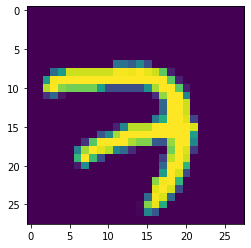

In [7]:
import matplotlib.pyplot as plt
#plotting the first image in dataset to get a idea how our dataset looks like
first_image = mnist.train.images[0]
first_image=first_image.reshape(28,28)
plt.imshow(first_image)

# Architecture of our model


    Convolution Layer(32 units), Filter shape:(5,5,1), Stride=1, Padding='SAME'
    Max pooling Layer, Window shape:(2,2), Stride=1, Padding='SAME'
    Convolution Layer(64 units), Filter shape:(5,5,32), Stride=1, Padding='SAME'
    Max pooling Layer, Window shape:(2,2), Stride=1, Padding='SAME'
    Dense Layer (1024 units)
    Output Layer (10 units)


# Initializing our constants

In [8]:
#input 
input_pixels = 784
input_width = 28
input_height = 28
input_channels = 1

#1st convolution layer
n_conv1 = 32
stride_conv1 = 1
padding_conv1="SAME"
filter_conv1_k = 5

#Pooling Layer1
max_pool1_k = 2
padding_pool1="SAME"


#2nd convolution layer
n_conv2 = 64
stride_conv2 = 1
padding_conv2="SAME"
filter_conv2_k = 5

#Pooling Layer2
max_pool2_k = 2
padding_pool2="SAME"

#dense layer
n_hidden = 1024

#output layer
n_out = 10

#### before we proceed we need to find the shape of input coming to hidden layer

In [9]:
hidden_width=input_width//(max_pool1_k*max_pool2_k)
hidden_height=input_height//(max_pool1_k*max_pool2_k)
hidden_channels=n_conv2

input_hidden =hidden_width*hidden_height*hidden_channels

# Initializing our weights and bias with random values

In [10]:
weights = {
    "weights_CL1" : tf.Variable(tf.random_normal([filter_conv1_k,filter_conv1_k, input_channels, n_conv1])),
    "weights_CL2" : tf.Variable(tf.random_normal([filter_conv2_k, filter_conv2_k, n_conv1, n_conv2])),
    "weights_hidden_layer" : tf.Variable(tf.random_normal([input_hidden, n_hidden])),
    "weights_output" : tf.Variable(tf.random_normal([n_hidden, n_out]))
}

biases = {
    "bias_CL1" : tf.Variable(tf.random_normal([n_conv1])),
    "bias_CL2" : tf.Variable(tf.random_normal([n_conv2])),
    "bias_hidden_layer" : tf.Variable(tf.random_normal([n_hidden])),
    "bias_output" : tf.Variable(tf.random_normal([n_out])),
}

    no weights are required for pooling layer
    number of wts for 1st covolutional layer is: filter(5x5) X input_channels x no of    units in layer
    similarly for 2nd convolutional layer


##  Functions for creating Convolution Layer and Pooling Layer

In [11]:
def conv(x, weights, bias, strides = 1,padding="VALID"):
    #creating a convolution layer
    out = tf.nn.conv2d(x, weights, padding=padding, strides = [1, strides, strides, 1])
    #adding bias
    out = tf.nn.bias_add(out, bias)
    #applying activation function,you can change activation func from relu to a different one if you want
    out = tf.nn.relu(out)
    return out



def maxpooling(x, k = 2,padding="VALID"):
    return tf.nn.max_pool(x, padding = padding, ksize = [1, k, k, 1], strides = [1, k, k, 1])

# CNN function

In [12]:
def cnn(x, weights, biases):
    
    #reshaping x into format of 
    x = tf.reshape(x, shape = [-1 ,input_height, input_width, input_channels])
    
    conv1 = conv(x, weights['weights_CL1'], biases['bias_CL1'], stride_conv1,padding_conv1)
    pool1 = maxpooling(conv1, max_pool1_k,padding_pool1)
    
    
    conv2 = conv(pool1, weights['weights_CL2'], biases['bias_CL2'],stride_conv2,padding_conv2)
    pool2 = maxpooling(conv2, max_pool2_k,padding_pool2)
    
    
    hidden_input = tf.reshape(pool2, shape = [-1, input_hidden])
    a=tf.add(tf.matmul(hidden_input, weights['weights_hidden_layer']), biases['bias_hidden_layer'])
    hidden_output = tf.nn.relu(a)
    
    
    #for output layer we're applying activation function
    output = tf.add(tf.matmul(hidden_output, weights['weights_output']), biases['bias_output'])

    return output

# Creating placeholders for x, y and prediction

In [13]:
x = tf.placeholder("float", [None, input_pixels])
y = tf.placeholder(tf.int32, [None, n_out])
pred = cnn(x, weights, biases)

# Creating our Cost function and Optimizer

In [14]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels = y))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
optimize = optimizer.minimize(cost)

# Calling session to start running our code

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
batch_size = 1000
for i in range(8):
    num_batches = int(mnist.train.num_examples/batch_size)
    for j in range(num_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        c, _ = sess.run([cost,optimize], feed_dict={x:batch_x , y:batch_y})
    
    print("Epoch "+str(i+1)+" cost is :",c)

Epoch 1 cost is : 348.6542
Epoch 2 cost is : 126.46548
Epoch 3 cost is : 122.805244
Epoch 4 cost is : 41.34507
Epoch 5 cost is : 27.618818
Epoch 6 cost is : 19.282413
Epoch 7 cost is : 9.250713
Epoch 8 cost is : 7.128848


# Accuracy

In [17]:
predictions = tf.argmax(pred, 1)
correct_labels = tf.argmax(y, 1)
correct_predictions = tf.equal(predictions, correct_labels)
predictions,correct_preds  = sess.run([predictions, correct_predictions], feed_dict={x:mnist.test.images,
                                              y:mnist.test.labels})

print("Accuracy is :", (correct_preds.sum()/mnist.test.images.shape[0])*100)

Accuracy is : 96.73
